In [2]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import torch

# get the accuracy metrics
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from mfbml.methods.mf_dnn_bnn import MFDNNBNN
from mfbml.methods.bnn import BNNWrapper
from mfbml.methods.sequential_mf_bnn import SequentialMFBNN
from mfbml.problems.illutrative_problems import mf_Forrester_torch
from mfbml.metrics import (
    mean_log_likelihood_value,
    normalized_mae,
    normalized_rmse,
)

# fix the random seed for reproducibility
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

In [16]:
# define function
func = mf_Forrester_torch(noise_std=0.0)

# generate samples (21 HF samples, 201 LF samples)
lf_samples = torch.linspace(0, 1, 201).reshape(-1, 1)
# hf_samples = lf_samples[::10]  # sample every 5 points
hf_samples = torch.linspace(0, 1, 7).reshape(-1, 1)

# generate responses
lf_responses = func.lf_1(lf_samples, noise_std=0.3)
hf_responses = func.hf(hf_samples, noise_hf=0.3)

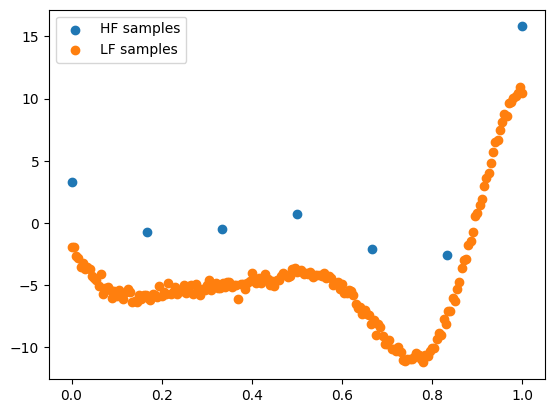

In [17]:
# generate the test points
test_samples = torch.linspace(0, 1, 101).reshape(-1, 1)
# noiseless responses
test_hf_responses_noiseless = func.hf(test_samples, noise_hf=0.0)
test_lf_responses_noiseless = func.lf_1(test_samples, noise_std=0.0)

# noise responses
test_hf_responses = func.hf(test_samples, noise_hf=0.3)
test_lf_responses = func.lf_1(test_samples, noise_std=0.3)

# plot the function
fig, ax = plt.subplots()
# ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
# ax.plot(test_samples, test_lf_responses_noiseless, label="LF")
# # plot test noisy responses
# ax.scatter(test_samples, test_hf_responses, label="HF noise responses")
# ax.scatter(test_samples, test_lf_responses, label="LF noise responses")
# plot the samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf_responses, label="LF samples")
plt.legend()
plt.show()

In [18]:
# calculate the person correlation coefficient via the noiseless responses
rho, pval = pearsonr(
    test_hf_responses_noiseless.flatten().numpy().tolist(),
    test_lf_responses_noiseless.flatten().numpy().tolist(),
)
print("rho: ", rho)
print("pval: ", pval)

rho:  0.9999999999999994
pval:  0.0


## Configurations for DNN and BNNs


In [19]:
# create the configuration of the low-fidelity model
lf_configure = {
    "in_features": 1,
    "hidden_features": [20, 20],
    "out_features": 1,
    "activation": "Tanh",
    "optimizer": "Adam",
    "lr": 0.001,
    "weight_decay": 0.000001,
    "loss": "mse",
}
# create the configuration of the high-fidelity model
hf_parallel_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}
#
hf_sequential_configure = {
    "in_features": 2,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}

# training configure
samples = {"lf": lf_samples, "hf": hf_samples}

responses = {"lf": lf_responses, "hf": hf_responses}

# lf train config
lf_train_config = {
    "batch_size": None,
    "num_epochs": 10000,
    "print_iter": 100,
    "data_split": False,
}
hf_train_config = {
    "num_epochs": 50000,
    "sample_freq": 100,
    "print_info": True,
    "burn_in_epochs": 20000,
}

### train standard BNN using HF data


In [20]:
# define BNN
bnn_model = BNNWrapper(
    in_features=1,
    hidden_features=[50, 50],
    out_features=1,
    activation="Tanh",
    lr=0.001,
    sigma=0.3,
)

# train the model
bnn_model.train(
    x=hf_samples,
    y=hf_responses,
    num_epochs=20000,
    sample_freq=100,
    burn_in_epochs=10000,
)

epoch:     0/20000
nll_loss: 1552.592, prior_loss: 2507.847, total: 4060.439
noise: 0.300
epoch:   100/20000
nll_loss: 1112.841, prior_loss: 2701.600, total: 3814.441
noise: 0.300
epoch:   200/20000
nll_loss: 927.820, prior_loss: 2814.827, total: 3742.647
noise: 0.300
epoch:   300/20000
nll_loss: 766.935, prior_loss: 2916.230, total: 3683.165
noise: 0.300
epoch:   400/20000
nll_loss: 612.563, prior_loss: 2999.198, total: 3611.761
noise: 0.300
epoch:   500/20000
nll_loss: 485.241, prior_loss: 3098.746, total: 3583.987
noise: 0.300
epoch:   600/20000
nll_loss: 364.382, prior_loss: 3170.811, total: 3535.193
noise: 0.300
epoch:   700/20000
nll_loss: 243.633, prior_loss: 3241.753, total: 3485.385
noise: 0.300
epoch:   800/20000
nll_loss: 183.012, prior_loss: 3294.207, total: 3477.219
noise: 0.300
epoch:   900/20000
nll_loss: 118.702, prior_loss: 3333.698, total: 3452.400
noise: 0.300
epoch:  1000/20000
nll_loss: 99.785, prior_loss: 3385.978, total: 3485.763
noise: 0.300
epoch:  1100/20000
n

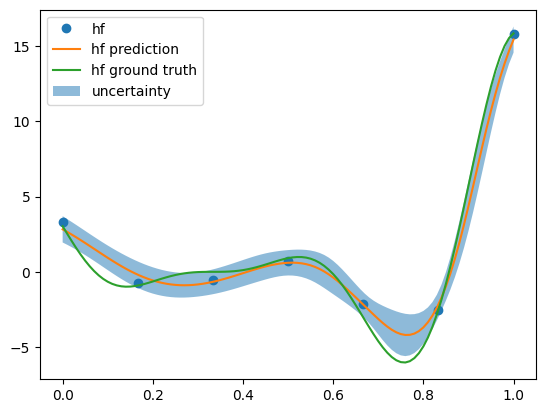

In [21]:
# visualize the posterior of bnn
bnn_y, bnn_epistemic, bnn_total_unc, bnn_aleatoric = bnn_model.predict(
    x=test_samples)

# plot
plt.figure()
plt.plot(hf_samples, hf_responses, "o", label="hf")
plt.plot(test_samples.numpy(), bnn_y, label="hf prediction")
plt.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
plt.fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_total_unc).reshape(-1),
    (bnn_y + 2 * bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
plt.legend()
# plt.savefig("bnn.png", bbox_inches='tight', dpi=300)
plt.show()

# training of sequential MF-DNN-BNN model


In [22]:
# sequential mf-bnn
sequential_bnn = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)
# train the model
sequential_bnn.train(
    samples=samples,
    responses=responses,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.9064114093780518
epoch:  200 train loss:  0.855586051940918
epoch:  300 train loss:  0.6209068298339844
epoch:  400 train loss:  0.31847959756851196
epoch:  500 train loss:  0.08251912146806717
epoch:  600 train loss:  0.02068205736577511
epoch:  700 train loss:  0.01584891974925995
epoch:  800 train loss:  0.014864263124763966
epoch:  900 train loss:  0.014178714714944363
epoch:  1000 train loss:  0.013569722883403301
epoch:  1100 train loss:  0.012981765903532505
epoch:  1200 train loss:  0.012388510629534721
epoch:  1300 train loss:  0.011766931042075157
epoch:  1400 train loss:  0.011073989793658257
epoch:  1500 train loss:  0.01019686833024025
epoch:  1600 train loss:  0.009075134992599487
epoch:  1700 train loss:  0.00793430209159851
epoch:  1800 train loss:  0.006982994265854359
epoch:  1900 train loss:  0.00625221524387598
epoch:  2000 train loss:  0.00568440230563283
epoch:  2100 train loss:  0.005306415259838

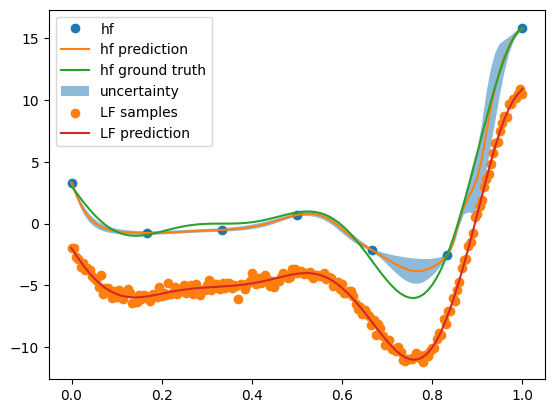

In [23]:
# visualize the posterior of sequential mf-bnn
(
    sequential_bnn_y,
    sequential_bnn_epistemic,
    sequential_bnn_total_unc,
    sequential_bnn_aleatoric,
) = sequential_bnn.predict(x=test_samples)
# get lf predictions
sequential_bnn_lf_y = sequential_bnn.predict_lf(x=test_samples)
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), sequential_bnn_y, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (sequential_bnn_y - 2 * sequential_bnn_total_unc).reshape(-1),
    (sequential_bnn_y + 2 * sequential_bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf_responses, label="LF samples")
ax.plot(
    test_samples.numpy(),
    sequential_bnn_lf_y.detach().numpy(),
    label="LF prediction"
)
ax.legend()
plt.show()

In [25]:
# create the MFDNNBNN object
mfdnnbnn = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=True,
    lf_order=1,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)
# define beta
mfdnnbnn.train(
    samples=samples,
    responses=responses,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.9194754958152771
epoch:  200 train loss:  0.8830741047859192
epoch:  300 train loss:  0.747355580329895
epoch:  400 train loss:  0.46510398387908936
epoch:  500 train loss:  0.2342219203710556
epoch:  600 train loss:  0.07165810465812683
epoch:  700 train loss:  0.030189402401447296
epoch:  800 train loss:  0.02357311174273491
epoch:  900 train loss:  0.02031686343252659
epoch:  1000 train loss:  0.01781037263572216
epoch:  1100 train loss:  0.016158251091837883
epoch:  1200 train loss:  0.014950060285627842
epoch:  1300 train loss:  0.013972610235214233
epoch:  1400 train loss:  0.013126012869179249
epoch:  1500 train loss:  0.012241892516613007
epoch:  1600 train loss:  0.01113913580775261
epoch:  1700 train loss:  0.009902776218950748
epoch:  1800 train loss:  0.00871320255100727
epoch:  1900 train loss:  0.007670246995985508
epoch:  2000 train loss:  0.006813721265643835
epoch:  2100 train loss:  0.0061451913788914

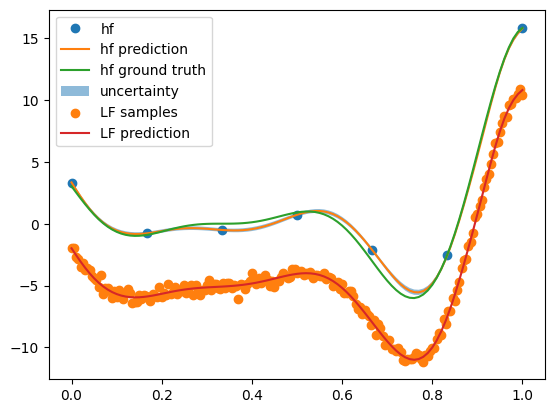

In [26]:
# predict the MFDNNBNN object
(
    y_proposed,
    epistemic_proposed,
    total_unc_proposed,
    aleatoric_proposed,
) = mfdnnbnn.predict(x=test_samples)
# lf prediction
lf_y_proposed = mfdnnbnn.predict_lf(test_samples)

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), y_proposed, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * total_unc_proposed).reshape(-1),
    (y_proposed + 2 * total_unc_proposed).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf_responses, label="LF samples")
ax.plot(test_samples.numpy(), lf_y_proposed.detach().numpy(),
        label="LF prediction")
ax.legend()
plt.show()

In [27]:
mfdnnbnn.beta

array([5.        , 0.98456816])

In [28]:
print("=====================================")
print("BNN")
nrmse_bnn = normalized_rmse(test_hf_responses_noiseless.numpy(), bnn_y)
print("nrmse: ", nrmse_bnn)
nmae_bnn = normalized_mae(test_hf_responses_noiseless.numpy(), bnn_y)
print("nmae: ", nmae_bnn)
ll_bnn = mean_log_likelihood_value(
    test_hf_responses.numpy(), bnn_y, bnn_total_unc)
print("ll_bnn: ", ll_bnn)
# r2 score
print("=====================================")
print("R2 Score")
print("BNN: ", r2_score(test_hf_responses_noiseless.numpy(), bnn_y))
# sequential mf-bnn
print("=====================================")
print("Sequential MF-BNN")
nrmse_sequential_bnn = normalized_rmse(
    test_hf_responses_noiseless.numpy(), sequential_bnn_y
)
print("nrmse: ", nrmse_sequential_bnn)
nmae_sequential_bnn = normalized_mae(
    test_hf_responses_noiseless.numpy(), sequential_bnn_y
)
print("nmae: ", nmae_sequential_bnn)
ll_sequential_bnn = mean_log_likelihood_value(
    test_hf_responses.numpy(),
    sequential_bnn_y,
    sequential_bnn_total_unc,
)
print("ll_sequential_bnn: ", ll_sequential_bnn)
# R2 Score
print("=====================================")
print("R2 Score")
print("BNN: ", r2_score(test_hf_responses_noiseless.numpy(), sequential_bnn_y))
# MFDNNBNN
print("=====================================")
print("MFDNNBNN")
nrmse_mfdnnbnn = normalized_rmse(
    test_hf_responses_noiseless.numpy(), y_proposed)
print("nrmse: ", nrmse_mfdnnbnn)
nmae_mfdnnbnn = normalized_mae(test_hf_responses_noiseless.numpy(), y_proposed)
print("nmae: ", nmae_mfdnnbnn)
ll_mfdnnbnn = mean_log_likelihood_value(
    test_hf_responses.numpy(), y_proposed, total_unc_proposed
)
print("ll_mfdnnbnn: ", ll_mfdnnbnn)
# R2 Score
print("=====================================")
print("R2 Score")
print("BNN: ", r2_score(test_hf_responses_noiseless.numpy(), y_proposed))

BNN
nrmse:  0.36479315
nmae:  0.70063514
ll_bnn:  -2.2989924
R2 Score
BNN:  0.9549969973893723
Sequential MF-BNN
nrmse:  0.31492132
nmae:  0.83758914
ll_sequential_bnn:  -14.580969
R2 Score
BNN:  0.9664608310685254
MFDNNBNN
nrmse:  0.15329729
nmae:  0.35090026
ll_mfdnnbnn:  -18.817448
R2 Score
BNN:  0.9920527452523098


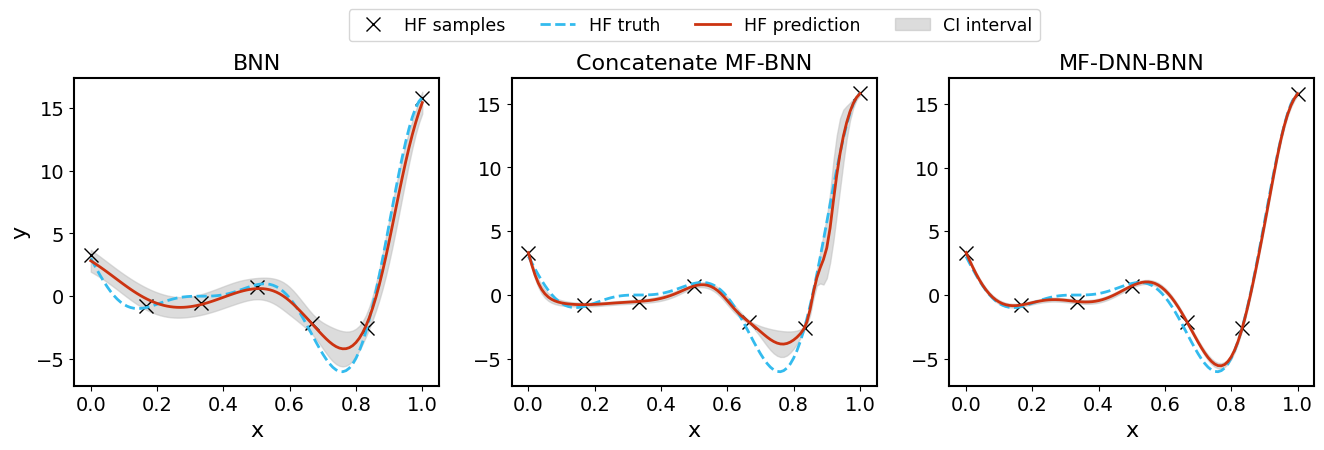

In [31]:
font_size = 16
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

# plot results of bnn
ax[0].plot(
    samples["hf"].numpy(),
    responses["hf"].numpy(),
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
ax[0].plot(
    test_samples.numpy(),
    bnn_y,
    "-",
    color="#CC3311",
    linewidth=2,
    label="HF prediction",
)
ax[0].fill_between(
    test_samples.flatten(),
    (bnn_y - 2 * bnn_total_unc).flatten(),
    (bnn_y + 2 * bnn_total_unc).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# ax[0].legend(loc="lower right")
ax[0].set_title("BNN", fontsize=font_size)
ax[0].set_xlabel("x", fontsize=font_size)
ax[0].set_ylabel("y", fontsize=font_size)
ax[0].tick_params(labelsize=font_size)
# ax[0].set_ylim([-2, 1.0])

#  plot for sequential mf-bnn
ax[1].plot(
    samples["hf"].numpy(),
    responses["hf"].numpy(),
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF noiseless truth",
)
ax[1].plot(
    test_samples.numpy(),
    sequential_bnn_y,
    "-",
    color="#CC3311",
    linewidth=2,
    label="HF prediction",
)

ax[1].fill_between(
    test_samples.flatten().numpy(),
    (sequential_bnn_y - 2 * sequential_bnn_total_unc).flatten(),
    (sequential_bnn_y + 2 * sequential_bnn_total_unc).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# ax[1].legend(loc="lower right")
ax[1].set_title("Concatenate MF-BNN", fontsize=font_size)
ax[1].set_xlabel("x", fontsize=font_size)
ax[1].set_ylabel(" ", fontsize=font_size)
ax[1].tick_params(labelsize=font_size)
# ax[1].set_ylim([-2, 1.0])

# plot for MFDNNBNN
ax[2].plot(
    samples["hf"].numpy(),
    responses["hf"].numpy(),
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[2].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
ax[2].plot(
    test_samples.numpy(),
    y_proposed,
    "-",
    color="#CC3311",
    linewidth=2,
    label="HF prediction",
)

ax[2].fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * total_unc_proposed).flatten(),
    (y_proposed + 2 * total_unc_proposed).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

ax[2].set_title("MF-DNN-BNN", fontsize=font_size)
ax[2].set_xlabel("x", fontsize=font_size)
ax[2].set_ylabel(" ", fontsize=font_size)
ax[2].tick_params(labelsize=font_size)
# ax[2].set_ylim([-2, 1.0])
# ax[2].legend(loc="lower right")
plt.legend(loc="upper center", bbox_to_anchor=(-0.7, 1.25),
           ncol=4, fontsize=12.5)

# set the font size of axis
for i in range(3):
    ax[i].tick_params(axis="both", which="major", labelsize=14)
    # set the line width of the axis
    for axis in ["top", "bottom", "left", "right"]:
        ax[i].spines[axis].set_linewidth(1.5)

plt.savefig("mf_dnn_bnn_known_noise.pdf", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_known_noise.png", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_known_noise.svg", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# error plot
fig, ax = plt.subplots(1, figsize=(6, 4))
# plot for sequential mf-bnn
ax.plot(
    test_samples.numpy(),
    np.abs(test_hf_responses_noiseless.numpy() - sequential_bnn_y),
    "-",
    color="#0077BB",
    linewidth=2,
    label="Meng's MF-BNN",
)
ax.plot(
    test_samples.numpy(),
    np.abs(test_hf_responses_noiseless.numpy() - y_proposed),
    "-",
    color="#EE7733",
    linewidth=2,
    label="MF-DNN-BNN",
)
ax.set_xlabel("x", fontsize=font_size)
ax.set_ylabel("Absolute error", fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.legend()
plt.tight_layout()
plt.savefig("mf_dnn_bnn_known_noise_error.pdf", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_known_noise_error.png", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_known_noise_error.svg", dpi=300, bbox_inches="tight")
plt.show()